Linear Regression Analysis

Para resolver la limitación de conectividad entre Databricks y una base de datos local, podemos optar por leer directamente el archivo CSV que generaste previamente. Esto es perfectamente válido y funcional para el flujo de trabajo de Machine Learning con Spark MLib.

A continuación te doy los pasos para que puedas cargar ese archivo CSV en Databricks y proceder a entrenar un modelo de Machine Learning con Spark MLib:

1. Cargar el archivo CSV en Databricks
Si tienes tu archivo CSV (ecommerce_data_cleaned.csv) guardado en tu máquina local, lo primero es cargarlo en el entorno de Databricks.

Opciones para cargar el archivo CSV en Databricks:
Subida manual: Puedes subir el archivo directamente al sistema de archivos de Databricks (DBFS).
Ve al menú de la izquierda en Databricks.
Haz clic en Data > Add Data > Upload File.
Sube el archivo ecommerce_data_cleaned.csv.

In [0]:
# Ruta donde se ha subido el archivo en DBFS (ajusta según la ubicación exacta)
file_path = "/FileStore/tables/ecommerce_data_cleaned.csv"

# Cargar los datos usando Spark
df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# Mostrar el esquema para asegurarte que los tipos de datos son correctos
df.printSchema()

# Ver algunas filas de ejemplo
df.show(10)



root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Month: integer (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+-----+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|           Revenue|Month|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+-----+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|   12|
|   536365|    71053| WHITE METAL LANTERN|       6|

2. Preprocesar los datos
Antes de entrenar un modelo, es importante preprocesar los datos. En este caso, por ejemplo, puedes transformar las columnas en vectores de características y dividir los datos en conjuntos de entrenamiento y prueba.

1.Aquí estamos asegurando que la columna Month, que originalmente podría ser un tipo de dato diferente (como float o string), se convierte explícitamente en un número entero (int). Esto es importante porque para el modelo de Machine Learning, queremos que las variables sean numéricas y no categóricas o de otro tipo.
2.En este paso, creamos una nueva columna llamada label en el DataFrame que contendrá el valor de la columna Revenue. En Machine Learning, la columna label es la variable objetivo (es decir, lo que intentamos predecir). El modelo va a aprender a partir de los datos (features) para predecir este valor.
3.El VectorAssembler toma varias columnas de entrada (Quantity, UnitPrice, y Month) y las combina en una sola columna llamada features. Esta nueva columna features será el conjunto de variables (o características) que alimentarán al modelo de Machine Learning para hacer las predicciones. En este caso, estamos usando:
Quantity (Cantidad de productos),
UnitPrice (Precio por unidad),
Month (Mes de la transacción).
4.El Pipeline permite organizar el flujo de trabajo de transformación de datos y modelado. Aquí solo tiene un paso: el VectorAssembler. Es decir, primero tomamos las columnas y las convertimos en vectores de características.
5.Aplicamos el pipeline a los datos (df_ml). Esto toma las columnas que mencionamos antes, las convierte en el formato requerido (vectores de características) y añade la columna features al DataFrame.
6.Esta línea simplemente muestra las primeras 10 filas de la columna features (nuestros vectores de características) y la columna label (los valores de ingresos o Revenue que queremos predecir).

Análisis del resultado:
Columnas de entrada (features): Las columnas Quantity, UnitPrice y Month han sido convertidas en una sola columna de tipo vector, donde cada fila contiene un vector con los valores de estas tres columnas. Por ejemplo, [6.0, 2.55, 12.0] significa que en esa transacción:
Se vendieron 6 unidades,
A un precio de 2.55 por unidad,
En el mes 12 (diciembre).
Variable objetivo (label): La columna label contiene los valores de los ingresos totales (Revenue) para cada fila. Esta es la variable que el modelo intentará predecir.
Por ejemplo, en una de las filas, el vector features es [6.0, 2.55, 12.0] y el label (ingreso total) es 15.3. Es decir, el modelo intentará aprender la relación entre las características (cantidad, precio y mes) para predecir los ingresos (Revenue).

Regresión lineal:
En este contexto, la regresión lineal es una elección sensata porque estamos tratando de predecir una variable continua (ingresos) basada en otras variables numéricas (cantidad, precio, mes). El modelo intentará encontrar la relación lineal entre estas variables y el Revenue.

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col

# Convertir la columna Month a tipo entero explícitamente
df_ml = df.withColumn("Month", col("Month").cast("int"))

# Continuar con el procesamiento como antes
df_ml = df_ml.withColumn("label", df["Revenue"])

assembler = VectorAssembler(inputCols=["Quantity", "UnitPrice", "Month"], outputCol="features")
pipeline = Pipeline(stages=[assembler])
df_prepared = pipeline.fit(df_ml).transform(df_ml)

df_prepared.select("features", "label").show(10)



+----------------+------------------+
|        features|             label|
+----------------+------------------+
| [6.0,2.55,12.0]|15.299999999999999|
| [6.0,3.39,12.0]|             20.34|
| [8.0,2.75,12.0]|              22.0|
| [6.0,3.39,12.0]|             20.34|
| [6.0,3.39,12.0]|             20.34|
| [2.0,7.65,12.0]|              15.3|
| [6.0,4.25,12.0]|              25.5|
| [6.0,1.85,12.0]|11.100000000000001|
| [6.0,1.85,12.0]|11.100000000000001|
|[32.0,1.69,12.0]|             54.08|
+----------------+------------------+
only showing top 10 rows



3. Dividir los datos en entrenamiento y prueba

In [0]:
# Dividimos los datos en conjunto de entrenamiento y prueba
train_data, test_data = df_prepared.randomSplit([0.8, 0.2])

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {train_data.count()}")
print(f"Tamaño del conjunto de prueba: {test_data.count()}")


Tamaño del conjunto de entrenamiento: 420665
Tamaño del conjunto de prueba: 105389


4. Entrenar el modelo con Spark MLlib
Usaremos un modelo simple de regresión lineal para predecir el Revenue basado en las características.

¿Por qué usamos regresión lineal y cuándo cambiar de modelo?
Regresión lineal se usa en problemas donde la relación entre las variables independientes (como Quantity, UnitPrice, etc.) y la variable dependiente (en este caso, Revenue) es lineal. Si asumimos que el ingreso aumenta linealmente con el precio y la cantidad, la regresión lineal puede capturar esta relación.

Sin embargo, no siempre un modelo de regresión lineal es la mejor opción. Dependiendo de la naturaleza del negocio, la distribución de los datos, y la complejidad de las relaciones entre las variables, se puede optar por otros modelos. Aquí hay algunas situaciones donde podríamos cambiar de modelo:

Relaciones no lineales: Si los datos no siguen una tendencia lineal. Por ejemplo, si el aumento en el precio provoca una disminución en la cantidad comprada, el modelo debe capturar esta curvatura.

Modelos recomendados:
Regresión polinomial
Árboles de decisión (capturan relaciones más complejas)
Random Forest
Clasificación: Si tu objetivo no es predecir un valor continuo como Revenue, sino más bien categorizar transacciones en grupos (por ejemplo, clientes leales vs. no leales).

Modelos recomendados:
Regresión logística
SVM (Máquinas de Vectores de Soporte)
Árboles de decisión
Series temporales: Si estás trabajando con datos temporales (ventas por mes, semana, etc.), y quieres hacer predicciones basadas en patrones de tiempo.

Modelos recomendados:
ARIMA
Prophet (para modelar tendencias y estacionalidades)
Grandes volúmenes de datos o complejidad alta: Si tienes un gran volumen de datos o una complejidad alta entre las variables que hace que un modelo lineal sea inadecuado.

Modelos recomendados:
Random Forest
XGBoost
Redes Neuronales
¿Cómo saber qué modelo elegir?
Algunas señales que indican la necesidad de un modelo diferente:

Distribución no lineal: Observa los gráficos de dispersión entre las variables. Si no muestran una relación lineal, entonces la regresión lineal no es adecuada.
Bajo desempeño de la regresión lineal: Si el error cuadrático medio (RMSE) es alto o el R² es bajo, es una señal de que el modelo no está capturando bien la relación entre las variables.
Dominancia de ciertos valores: Si el dataset está desequilibrado (por ejemplo, muchas transacciones pequeñas y pocas grandes), es posible que un modelo más robusto como random forest o XGBoost sea más eficaz.

1.Aquí estamos creando un objeto de regresión lineal de la librería de PySpark MLlib. Este modelo utiliza las características (featuresCol="features") para intentar predecir la columna objetivo (labelCol="label", que en este caso es el ingreso Revenue).
2. Entrenar el modelo:Estamos entrenando el modelo con los datos de entrenamiento (train_data). El modelo ajusta una línea (o hiperplano en casos multivariables) para intentar capturar la relación entre las variables predictoras (features) y la variable objetivo (label).
3.Después de entrenar el modelo, evaluamos su rendimiento con los datos de prueba (test_data). Aquí se analiza cómo el modelo entrenado generaliza a datos que no ha visto antes.
4.l RMSE (Root Mean Squared Error) mide el promedio de la magnitud de los errores entre las predicciones del modelo y los valores reales. Es una métrica clave para modelos de regresión. Cuanto más bajo sea el RMSE, mejor está funcionando el modelo.

Análisis del resultado:
RMSE: 131.8571

Este valor nos dice que, en promedio, el modelo tiene un error de aproximadamente 131.85 unidades monetarias (asumiendo que los ingresos se miden en alguna moneda) al predecir el ingreso Revenue. Este número refleja el grado de precisión del modelo. Si el RMSE es alto, significa que el modelo no está prediciendo de manera precisa.

In [0]:
# Definir el modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="label")

# Entrenar el modelo
lr_model = lr.fit(train_data)

# Evaluar el modelo en los datos de prueba
test_results = lr_model.evaluate(test_data)

# Imprimir el error cuadrático medio (RMSE)
print(f"RMSE: {test_results.rootMeanSquaredError}")


RMSE: 131.8571551027136


5. Hacer predicciones con el modelo entrenado
Puedes usar el modelo para hacer predicciones sobre nuevos datos o sobre el conjunto de prueba:

1. Comparar el RMSE con la escala de la variable objetivo:
El primer paso es observar la magnitud de la variable objetivo, en este caso el ingreso (Revenue). El RMSE mide el error medio en las unidades de la variable que estamos tratando de predecir. Debemos ver si un error de 131 unidades es significativo comparado con el rango típico de ingresos.

Si los ingresos promedio son mucho más grandes (por ejemplo, 1000-5000), entonces un RMSE de 131 podría ser aceptable.
Si los ingresos están alrededor de 100-500, entonces un RMSE de 131 es probablemente demasiado alto.
2. División del dataset:
Distribución de Revenue: Un análisis de la distribución de la variable Revenue es clave. ¿Es muy dispersa, con ingresos que van desde valores bajos (por ejemplo, menos de 10) hasta ingresos muy altos (por ejemplo, más de 500)? Si es así, podríamos esperar que el RMSE sea mayor.
Para visualizar esto, podemos graficar el histograma de Revenue y observar la distribución



Podemos analizar otras métricas como el Mean Absolute Error (MAE), que mide el error promedio absoluto sin elevarlo al cuadrado, y R² (coeficiente de determinación), que mide qué tan bien el modelo ajusta los datos en una escala de 0 a 1.

In [0]:
print(f"MAE: {test_results.meanAbsoluteError}")
print(f"R²: {test_results.r2}")

MAE: 11.104848964380473
R²: 0.19472034306316977


Revisar el impacto de las características:
Otro aspecto clave es analizar qué tan fuertes son las relaciones entre las variables predictoras (en este caso, Quantity, UnitPrice, Month) y el Revenue. Quizás hay otras variables importantes que no hemos incluido, o quizá alguna variable no tiene tanta influencia en el ingreso.

Análisis de correlación: Podríamos analizar la correlación entre las características y la variable objetivo:

In [0]:
df_ml.corr("Quantity", "Revenue")
df_ml.corr("UnitPrice", "Revenue")

Out[10]: 0.1582833446566748

Visualizar los residuos del modelo:
Analizar los residuos del modelo (las diferencias entre las predicciones y los valores reales) también puede proporcionar información importante. Si los residuos están distribuidos de manera simétrica alrededor de 0, el modelo está funcionando razonablemente bien.

+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|11.296106608938958|              15.3|
| 11.11870282252547|             17.85|
|14.057835286132027|              25.5|
| 76.03375271370597|              40.8|
| 31.42977426575197|              53.1|
| 22.89695229753819|              45.0|
|32.402245213425324|              17.0|
| 41.59616979765846|              90.0|
|  40.7793830158121| 70.80000000000001|
|14.772523720247593|29.700000000000003|
|11.296106608938958|              15.3|
|13.179789495647192|             20.34|
| 13.69795442484344|              27.8|
|15.642896320190152|              22.0|
|11.607474940592954|11.100000000000001|
|  16.8195639633251|               8.5|
|19.936100213345146|              10.2|
|17.942645788363844|              19.5|
| 38.32902267027303|13.200000000000001|
|13.547343547478054|              22.5|
+------------------+------------------+
only showing top 20 rows



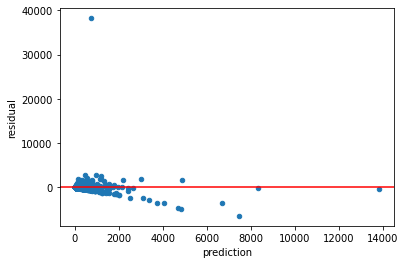

In [0]:
predictions = lr_model.transform(test_data)
predictions.select("prediction", "label").show()

# Convert to pandas for visualization
import matplotlib.pyplot as plt
import pandas as pd
pred_df = predictions.select("prediction", "label").toPandas()
pred_df["residual"] = pred_df["label"] - pred_df["prediction"]
pred_df.plot.scatter(x="prediction", y="residual")
plt.axhline(0, color='red')
plt.show()


In [0]:
# Predicciones en los datos de prueba
predictions = lr_model.transform(test_data)

# Mostrar las predicciones junto con los valores reales
predictions.select("prediction", "label", "features").show(50)


+------------------+------------------+-----------------+
|        prediction|             label|         features|
+------------------+------------------+-----------------+
|11.296106608938958|              15.3|  [2.0,7.65,12.0]|
| 11.11870282252547|             17.85|  [3.0,5.95,12.0]|
|14.057835286132027|              25.5|  [6.0,4.25,12.0]|
| 76.03375271370597|              40.8| [48.0,0.85,12.0]|
| 31.42977426575197|              53.1| [18.0,2.95,12.0]|
| 22.89695229753819|              45.0| [12.0,3.75,12.0]|
|32.402245213425324|              17.0| [20.0,0.85,12.0]|
| 41.59616979765846|              90.0| [24.0,3.75,12.0]|
|  40.7793830158121| 70.80000000000001| [24.0,2.95,12.0]|
|14.772523720247593|29.700000000000003|  [6.0,4.95,12.0]|
|11.296106608938958|              15.3|  [2.0,7.65,12.0]|
|13.179789495647192|             20.34|  [6.0,3.39,12.0]|
| 13.69795442484344|              27.8|  [4.0,6.95,12.0]|
|15.642896320190152|              22.0|  [8.0,2.75,12.0]|
|11.6074749405

1. Distribución del Revenue:
El gráfico muestra que la mayoría de los valores de Revenue están cerca de cero, con algunos puntos extremadamente grandes, lo que sugiere una distribución sesgada. Esto explica la dificultad del modelo para ajustar bien los datos, ya que valores de ingresos extremadamente altos pueden influir en las predicciones, resultando en un RMSE elevado.

La dispersión en los datos también sugiere que podrías tener outliers o datos con variabilidad que el modelo de regresión lineal no captura adecuadamente.

2. Gráfico de residuos:
En el gráfico de los residuos (predicciones menos valores reales) se observa que para la mayoría de los valores bajos de Revenue, los residuos están cercanos a cero, lo cual es una señal positiva. Sin embargo, para valores de predicción más altos (como en el rango de 3000 a 14000), los residuos se disparan, lo que sugiere que el modelo tiene dificultades para predecir valores más altos de Revenue.

Conclusión del gráfico: El modelo de regresión lineal parece ajustarse bien a los valores más bajos de Revenue, pero no es adecuado para capturar los ingresos más altos. Esto podría deberse a la naturaleza lineal del modelo que no puede capturar relaciones no lineales complejas en los datos.

3. MAE y R²:
MAE (Error Absoluto Medio): 11.10 significa que, en promedio, el modelo se equivoca por aproximadamente 11 unidades de Revenue en cada predicción. Esto podría parecer razonable si la mayoría de los valores de Revenue están en un rango similar, pero si hay valores mucho más altos, el error podría ser significativo.

R² (Coeficiente de determinación): 0.19 indica que el modelo explica solo el 19% de la variabilidad total de los datos. Esto es muy bajo, lo que sugiere que el modelo no está capturando bien las relaciones entre las variables predictoras y la variable objetivo Revenue.

4. Correlación entre las variables:
La correlación entre Quantity y Revenue es 0.158, lo cual es muy baja, sugiriendo que la cantidad de productos comprados no es un predictor fuerte de los ingresos.
La correlación entre UnitPrice y Revenue es también baja, lo que indica que los precios unitarios no están fuertemente relacionados con los ingresos, al menos de forma lineal.
Posibles conclusiones y mejoras:
Regresión lineal no es adecuada para este dataset: Dado el bajo valor de R² y los altos errores en los ingresos más grandes, la regresión lineal no es el modelo ideal. Podrías intentar usar modelos no lineales como árboles de decisión, random forests o incluso regresión polinómica para capturar relaciones más complejas entre las variables.

Eliminar o tratar los outliers: Valores extremos de Revenue pueden estar afectando la calidad del modelo. Puedes considerar eliminar o tratar estos outliers antes de entrenar nuevamente.

Agregar más características: La baja correlación sugiere que las tres características actuales (Quantity, UnitPrice, Month) no son suficientes para predecir el Revenue. Quizás otras variables como la categoría del producto, el cliente, o el día de la semana podrían mejorar el modelo.

Normalización o estandarización de los datos: Debido a la disparidad en las escalas de los datos, especialmente Revenue, podrías aplicar técnicas de escalado o normalización para hacer que los modelos funcionen mejor.

6. Opcional: Guardar el modelo
Si deseas guardar el modelo entrenado para su uso futuro:

In [0]:
# Guardar el modelo en DBFS
lr_model.save("/dbfs/ml_models/linear_regression_ecommerce_model")
